# Exploratory Data Analysis of some Eurostat Datasets

This started from me reading some news stories from Eurostat, and noticing a certain East/West divide in the maps accompanying the story. I look at a few datasets from recent Eurostat stories, and use the opportunity to try the pandas plotting functions.

In [3]:
import pandas as pd
from scipy import stats
import numpy as np

## Raw data
[Human resources in science and technology by sex, country](https://ec.europa.eu/eurostat/en/web/products-eurostat-news/w/ddn-20240613-2). $ scientists = T $ , total scientists and technologists. F is total female scientists and technologists.  $ fem_{scitech} = {F \over T } $ .  
[Working hours per week](https://ec.europa.eu/eurostat/en/web/products-eurostat-news/w/ddn-20240530-1) from European health interview survey.   
[Household consumption, price levels](https://ec.europa.eu/eurostat/en/web/products-eurostat-news/w/ddn-20240620-2) from Purchasing power parities (PPPs), price level indices and real expenditures.   
[People employed in finance and insurance](https://ec.europa.eu/eurostat/en/web/products-eurostat-news/w/ddn-20240610-2) from Enterprises by detailed NACE Rev.2 activity and special aggregates. 

In [4]:
hrst_st_rsex=pd.read_csv('data/hrst_st_rsex_page_linear.csv')
lfsa_ewhais=pd.read_csv('data/lfsa_ewhais_page_linear.csv')
prc_ppp_ind=pd.read_csv('data/prc_ppp_ind_page_linear.csv')
sbs_ovw_act=pd.read_csv('data/sbs_ovw_act_page_linear.csv')

In [5]:
def fem_tot_ratio(df):
    return (df.pivot(index='geo',columns='sex',values='OBS_VALUE')['F']
            /df.pivot(index='geo',columns='sex',values='OBS_VALUE')['T'])

## Process data

In [8]:
def process_csv(df):
    '''Limit the data to a list of countries of interest. Avoid the EU27 mean values, 
    and countries which appear in some datasets and not others. '''
    return (df
            .query("geo in ('AT','BE','BG','CY','CZ','DE','DK','EE','EL'"+
                   ",'ES','FI','FR','HR','HU','IE','IT','LT','LU','LV'"+
                   ",'MT','NL','NO','PL','PT','RO','RS','SE','SI','SK')")
            .set_index('geo')[['OBS_VALUE']]
           )

In [9]:
def normalised_negpos(df):
    ''' 0 to 1 is fine for parallel coordinates, but -1 to 1 improves Andrews curves'''
    return 2*((df-df.min())/(df.max()-df.min()))-1
#-1 for df.min() to +1 for df.max()

In [10]:
def process_log_csv(df):
    ''' option of treating columns that appear log normally distributed'''
    return (np
            .log(
                df
                .query("geo in ('AT','BE','BG','CY','CZ','DE','DK','EE','EL'"+
                       ",'ES','FI','FR','HR','HU','IE','IT','LT','LU','LV'"+
                       ",'MT','NL','NO','PL','PT','RO','RS','SE','SI','SK')")
                .set_index('geo')[['OBS_VALUE']]
            )
           )

 G7: Canada, France, Germany, Italy, Japan, the United Kingdom and the United States, the relevant to Eurostat are France, Germany, Italy. I opted for a mostly geographic definition of Eastern European countries, including historic NATO member Greece, non aligned former Yugoslavia and Cyprus, but not Finland. Note that modern Germany includes the former German Democratic Republic (East Germany) though overall numbers probably dominated by Berlin and former West Germany.

In [12]:
merged_stats=(lfsa_ewhais
 .pipe(process_csv)
 .pipe(normalised_negpos)
 .rename(columns={"OBS_VALUE":"weekly_h"})
 .assign(fem_scitech=
         pd.DataFrame(fem_tot_ratio(hrst_st_rsex))
         .rename(columns={0:'OBS_VALUE'})
         .reset_index()
         .pipe(process_csv)
         .pipe(normalised_negpos),
         financiers=sbs_ovw_act
        .pipe(process_csv)
        .pipe(normalised_negpos),
         scientists= hrst_st_rsex
        .query("sex=='T'")
        .pipe(process_csv)
        .pipe(normalised_negpos),
         prices=prc_ppp_ind
        .pipe(process_csv)
        .pipe(normalised_negpos),
         financiers_log=sbs_ovw_act
        .pipe(process_log_csv)
        .pipe(normalised_negpos),
         scientists_log= hrst_st_rsex
        .query("sex=='T'")
        .pipe(process_log_csv)
        .pipe(normalised_negpos),
         prices_log=prc_ppp_ind
        .pipe(process_log_csv)
        .pipe(normalised_negpos),
         east_west_g7=pd.Series(data=['W','W','E','E','E','G7','W','E','E',
                                      'W','W','G7','E','E','W','G7','E','W',
                                      'E','W','W','W','E','W','E','E','W','E','E'],
                             index=['AT', 'BE', 'BG', 'CY', 'CZ', 'DE', 'DK', 
                                    'EE', 'EL', 'ES', 'FI', 'FR', 'HR', 'HU', 
                                    'IE', 'IT', 'LT', 'LU', 'LV', 'MT', 'NL', 
                                    'NO', 'PL', 'PT', 'RO', 'RS', 'SE', 'SI', 'SK'])
        )
             )

## Visualise data

In [13]:
log_columns=['financiers_log','scientists_log','prices_log']

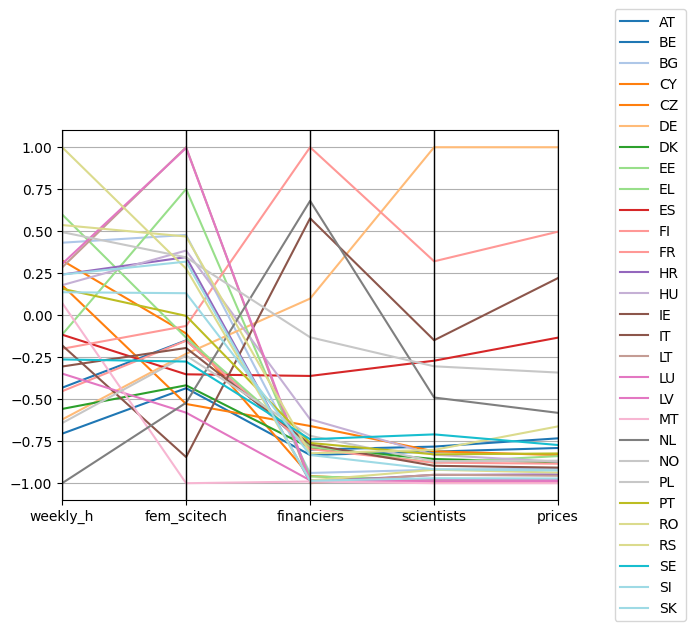

In [14]:
(pd
 .plotting
 .parallel_coordinates(merged_stats
                       .drop(columns=log_columns)
                       .drop(columns=['east_west_g7'])
                       .reset_index()
                       ,'geo'
                       ,colormap='tab20')
 .legend(loc='center left',bbox_to_anchor=(1.1, 0.5))
)

Too many colours. Immediately obvious that the first two columns are well spread, whereas the next three have a few outliers at the top and all the other values cluster together.

In [15]:
merged_stats.drop(columns=log_columns).sort_values(['financiers'],ascending=False).iloc[0:6]

,weekly_h,fem_scitech,financiers,scientists,prices,east_west_g7
geo,,,,,,
FR,-0.200000,-0.063945,1.000000,0.320828,0.497446,G7
NL,-1.000000,-0.520868,0.680729,-0.489892,-0.581179,W
IT,-0.178947,-0.844184,0.577021,-0.148937,0.221535,G7
DE,-0.621053,-0.229685,0.098964,1.000000,1.000000,G7
PL,0.494737,0.344461,-0.131210,-0.304077,-0.341279,E
ES,-0.115789,-0.351763,-0.361473,-0.270741,-0.133307,W


In [16]:
merged_stats.drop(columns=log_columns).sort_values(['prices'],ascending=False).iloc[0:6]

,weekly_h,fem_scitech,financiers,scientists,prices,east_west_g7
geo,,,,,,
DE,-0.621053,-0.229685,0.098964,1.000000,1.000000,G7
FR,-0.200000,-0.063945,1.000000,0.320828,0.497446,G7
IT,-0.178947,-0.844184,0.577021,-0.148937,0.221535,G7
ES,-0.115789,-0.351763,-0.361473,-0.270741,-0.133307,W
PL,0.494737,0.344461,-0.131210,-0.304077,-0.341279,E
NL,-1.000000,-0.520868,0.680729,-0.489892,-0.581179,W


In [17]:
merged_stats.drop(columns=log_columns).sort_values(['scientists'],ascending=False).iloc[0:6]

,weekly_h,fem_scitech,financiers,scientists,prices,east_west_g7
geo,,,,,,
DE,-0.621053,-0.229685,0.098964,1.000000,1.000000,G7
FR,-0.200000,-0.063945,1.000000,0.320828,0.497446,G7
IT,-0.178947,-0.844184,0.577021,-0.148937,0.221535,G7
ES,-0.115789,-0.351763,-0.361473,-0.270741,-0.133307,W
PL,0.494737,0.344461,-0.131210,-0.304077,-0.341279,E
NL,-1.000000,-0.520868,0.680729,-0.489892,-0.581179,W


G7 members and other big countries like Spain, Poland, and Netherlands are the outliers on top. 

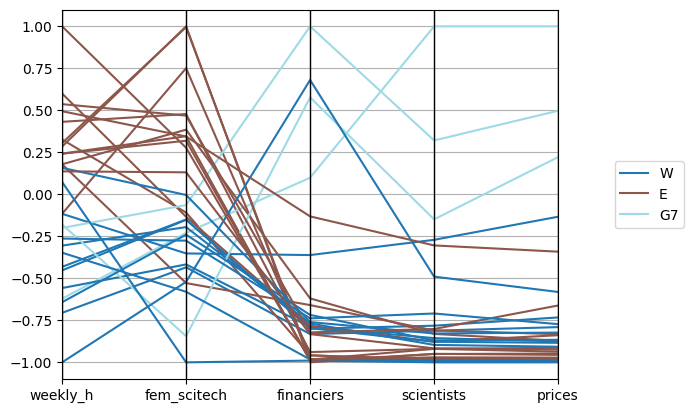

In [18]:
(pd
 .plotting
 .parallel_coordinates(merged_stats.drop(columns=log_columns),'east_west_g7',colormap='tab20')
 .legend(loc='center left',bbox_to_anchor=(1.1, 0.5))
)

Parallel coordinates crowded for prices, scientists and financiers near 0.0-0.2, G7 and other comparable countries are outliers at the top.

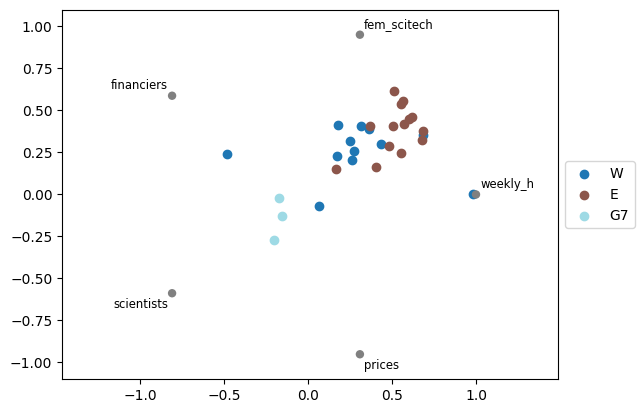

In [19]:
(pd
 .plotting
 .radviz(merged_stats.drop(columns=log_columns),'east_west_g7',colormap='tab20')
 .legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
)

Radviz slice between females in science/technology and weekly hours shows the best spread. G7 and a couple of others are outliers in the centre in the scientists/financiers slice.

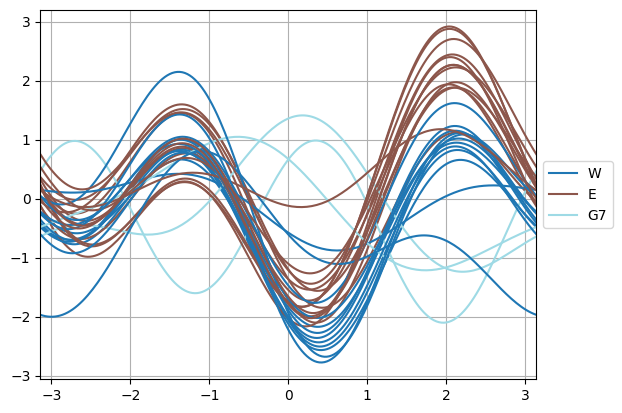

In [20]:
(pd
 .plotting
 .andrews_curves(merged_stats.drop(columns=log_columns),'east_west_g7',colormap='tab20')
 .legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
)

> $ f(t) = \frac{x_1}{\sqrt{2}} + x_2 \sin(t) + x_3 \cos(t) + x_4 \sin(2t) + x_5 \cos(2t)  $
Where x coefficients correspond to the values of each dimension
and t is linearly spaced between $ -\pi$ and $+\pi$ .
Each row of frame then corresponds to a single curve.

So the first coefficient is the dc component, the next two the in phase and quadrature component of the fundamental, and the next two the in phase and quadrature component of the first harmonic. 
- Most countries stuck together, again G7 and a couple of others stand out. 

array([[<Axes: xlabel='weekly_h', ylabel='weekly_h'>,
        <Axes: xlabel='fem_scitech', ylabel='weekly_h'>,
        <Axes: xlabel='financiers', ylabel='weekly_h'>,
        <Axes: xlabel='scientists', ylabel='weekly_h'>,
        <Axes: xlabel='prices', ylabel='weekly_h'>],
       [<Axes: xlabel='weekly_h', ylabel='fem_scitech'>,
        <Axes: xlabel='fem_scitech', ylabel='fem_scitech'>,
        <Axes: xlabel='financiers', ylabel='fem_scitech'>,
        <Axes: xlabel='scientists', ylabel='fem_scitech'>,
        <Axes: xlabel='prices', ylabel='fem_scitech'>],
       [<Axes: xlabel='weekly_h', ylabel='financiers'>,
        <Axes: xlabel='fem_scitech', ylabel='financiers'>,
        <Axes: xlabel='financiers', ylabel='financiers'>,
        <Axes: xlabel='scientists', ylabel='financiers'>,
        <Axes: xlabel='prices', ylabel='financiers'>],
       [<Axes: xlabel='weekly_h', ylabel='scientists'>,
        <Axes: xlabel='fem_scitech', ylabel='scientists'>,
        <Axes: xlabel='financier

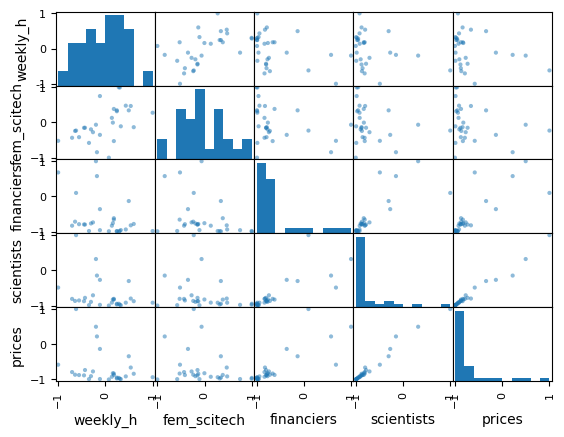

In [21]:
pd.plotting.scatter_matrix(
merged_stats
    .drop(columns=log_columns)
    .drop(columns=['east_west_g7'])
)

Some scatterplots show correlation, but with the data concentrated at the origin and a few outliers, which will be G7 and similar countries.

In [22]:
(merged_stats
 .drop(columns=log_columns)
 .drop(columns=['east_west_g7'])
 .corr()# .style.background_gradient(cmap='RdBu', vmin=-1, vmax=1) 
)

,weekly_h,fem_scitech,financiers,scientists,prices
weekly_h,1.000000,0.525280,-0.382036,-0.312867,-0.281540
fem_scitech,0.525280,1.000000,-0.335678,-0.229587,-0.250826
financiers,-0.382036,-0.335678,1.000000,0.786460,0.804731
scientists,-0.312867,-0.229587,0.786460,1.000000,0.985902
prices,-0.281540,-0.250826,0.804731,0.985902,1.000000


## Log transformation for Financiers, Scientists and Price Index

see [You're probably overthinking it](https://allendowney.github.io/ProbablyOverthinkingIt/intro.html) . Datasets where most values are clustered together with a few outliers far away from the cluster at origin but also from each other, might be better thought of as log normally distributed

In [23]:
lin_columns=['financiers','scientists','prices']

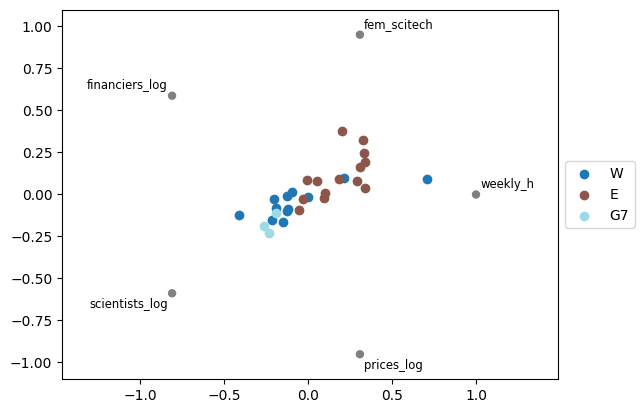

In [24]:
(pd
 .plotting
 .radviz(merged_stats.drop(columns=lin_columns),'east_west_g7',colormap='tab20')
 .legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
)
#,colors={'W':'tab_bluew','E':'tab_red'}

G7 part of the continuum of points now that log has been applied.

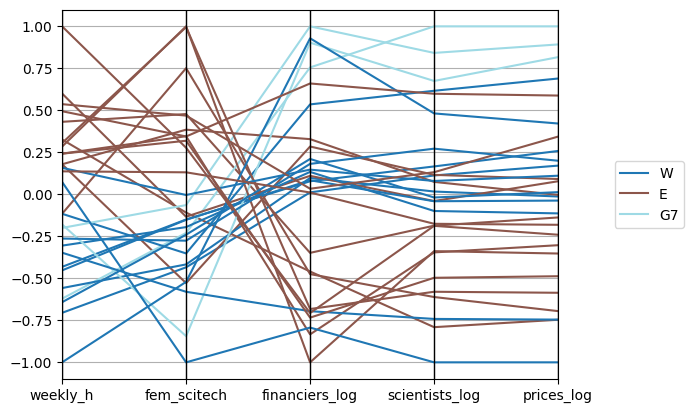

In [25]:
(pd
 .plotting
 .parallel_coordinates(merged_stats.drop(columns=lin_columns),'east_west_g7',colormap='tab20')
 .legend(loc='center left',bbox_to_anchor=(1.1, 0.5))
)

Parallel coordinates better spread out with log.

In [26]:
merged_stats.sort_values(['prices'],ascending=True).iloc[0:6]

,weekly_h,fem_scitech,financiers,scientists,prices,financiers_log,scientists_log,prices_log,east_west_g7
geo,,,,,,,,,
MT,0.073684,-1.000000,-0.989663,-1.000000,-1.000000,-0.793091,-1.000000,-1.000000,W
CY,0.326316,-0.108632,-0.957045,-0.992040,-0.990701,-0.459377,-0.790673,-0.746469,E
LU,-0.347368,-0.580033,-0.982678,-0.989457,-0.990659,-0.695581,-0.741589,-0.745643,W
EE,-0.115789,0.750936,-0.959190,-0.980754,-0.987922,-0.474709,-0.611231,-0.695120,E
LV,0.305263,0.995182,-0.981621,-0.978182,-0.980579,-0.682638,-0.579881,-0.585937,E
SI,0.242105,0.318983,-0.985612,-0.970256,-0.971843,-0.733776,-0.496785,-0.487446,E


Malta and Luxembourg stand out from western countries as having low prices!

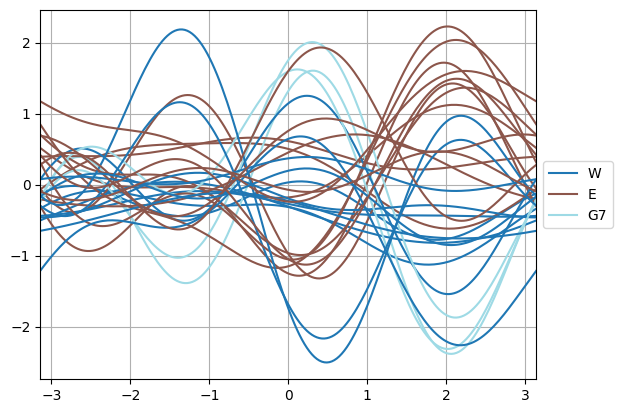

In [27]:
(pd
 .plotting
 .andrews_curves(merged_stats.drop(columns=lin_columns),'east_west_g7',colormap='tab20')
 .legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
)

Andrews curves better spread out with log.

### Conclusions

G7 expensive, and with a lot of people working in science and finance/insurance. They stand out from the rest and from each other.  
Eastern Europe: People work long hours, much higher percentage of women in science and technology. These dimensions form a continuum, most east european countries occupy the top half of the continuum but there is no clear clustering and no empty space between Eastern and Western Europe

In [28]:
(merged_stats
 .drop(columns=['east_west_g7'])
 .drop(columns=lin_columns)
 .corr() # .style.background_gradient(cmap='RdBu', vmin=-1, vmax=1)
)

,weekly_h,fem_scitech,financiers_log,scientists_log,prices_log
weekly_h,1.000000,0.525280,-0.443974,-0.319816,-0.288762
fem_scitech,0.525280,1.000000,-0.418424,-0.221371,-0.229726
financiers_log,-0.443974,-0.418424,1.000000,0.892595,0.881933
scientists_log,-0.319816,-0.221371,0.892595,1.000000,0.991712
prices_log,-0.288762,-0.229726,0.881933,0.991712,1.000000


Better R values especially between scientists and prices, after log is applied.

array([[<Axes: xlabel='weekly_h', ylabel='weekly_h'>,
        <Axes: xlabel='fem_scitech', ylabel='weekly_h'>,
        <Axes: xlabel='financiers_log', ylabel='weekly_h'>,
        <Axes: xlabel='scientists_log', ylabel='weekly_h'>,
        <Axes: xlabel='prices_log', ylabel='weekly_h'>],
       [<Axes: xlabel='weekly_h', ylabel='fem_scitech'>,
        <Axes: xlabel='fem_scitech', ylabel='fem_scitech'>,
        <Axes: xlabel='financiers_log', ylabel='fem_scitech'>,
        <Axes: xlabel='scientists_log', ylabel='fem_scitech'>,
        <Axes: xlabel='prices_log', ylabel='fem_scitech'>],
       [<Axes: xlabel='weekly_h', ylabel='financiers_log'>,
        <Axes: xlabel='fem_scitech', ylabel='financiers_log'>,
        <Axes: xlabel='financiers_log', ylabel='financiers_log'>,
        <Axes: xlabel='scientists_log', ylabel='financiers_log'>,
        <Axes: xlabel='prices_log', ylabel='financiers_log'>],
       [<Axes: xlabel='weekly_h', ylabel='scientists_log'>,
        <Axes: xlabel='fem_scit

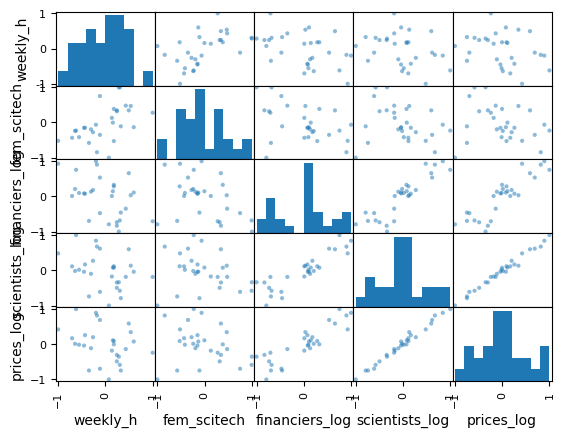

In [29]:
pd.plotting.scatter_matrix(
merged_stats
    .drop(columns=['east_west_g7'])
    .drop(columns=lin_columns)
)

Scatterplots for scientists vs prices much more plausibly linear now.

In [30]:
stats.linregress(merged_stats['prices_log'],y=merged_stats['financiers_log'])

LinregressResult(slope=0.9916743879209692, intercept=-0.009162346640124615, rvalue=0.8819328550633373, pvalue=2.5912874269495623e-10, stderr=0.1020042543930972, intercept_stderr=0.0510366384131093)

In [31]:
stats.linregress(merged_stats['prices'],y=merged_stats['scientists'])

LinregressResult(slope=0.9064390174192031, intercept=-0.08518599597008747, rvalue=0.9859022560656725, pvalue=1.6746525137722432e-22, stderr=0.029605785783045683, intercept_stderr=0.02467180254331601)

In [32]:
stats.linregress(merged_stats['prices_log'],y=merged_stats['scientists_log'])

LinregressResult(slope=0.9572225497796611, intercept=-0.01726150470693717, rvalue=0.9917120623870678, pvalue=1.3310277147106081e-25, stderr=0.023866127511794427, intercept_stderr=0.011941138410233205)

Prices vs scientists looks much more linear once log appled to both. The r value is much nearer to 1, the p value is much smaller compared to prices vs financiers. Change between linear and log is less obvious in the R value, but very obvious in the scatterplot.